In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import h5py
import json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Convolution2D
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Pre-processing

In [2]:
data_path='./data/udacity/'

df=pd.read_csv(data_path+'driving_log.csv', skiprows=1,skipinitialspace=True,
              names=['center','left','right','steering','throttle','brake','speed'])


In [3]:
steering_center=np.float32(df['steering'])
steering_left=np.float32(df['steering']+0.25)
steering_right=np.float32(df['steering']-0.25)

steerings=np.hstack((steering_center,steering_left,steering_right))
frames=np.hstack((df['center'],df['left'],df['right']))

In [4]:
idxs=np.where(abs(steerings)>0.5)
steerings=np.hstack((steerings,steerings[idxs],steerings[idxs]))
frames=np.hstack((frames, frames[idxs], frames[idxs]))

frames, steerings=shuffle(frames, steerings)

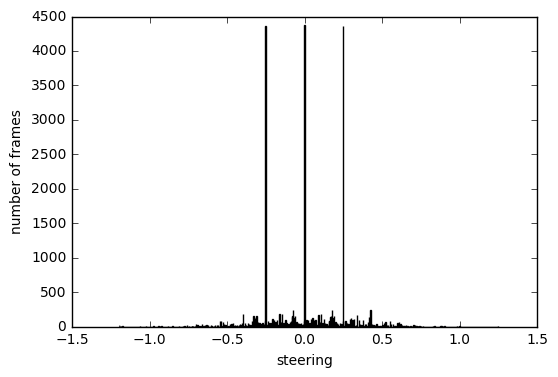

In [5]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.hist(steerings,bins=1000)
ax.set_xlabel('steering')
ax.set_ylabel('number of frames')
plt.show()

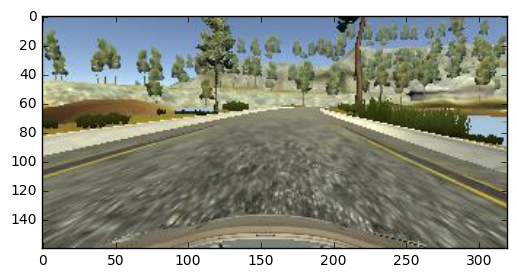

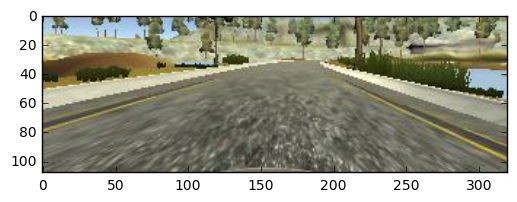

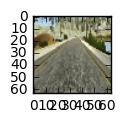

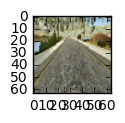

In [6]:
# Display image
img=cv2.imread(data_path+frames[1000])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

# Remove top and bottom pixels
img=img[32:-20,:,:]
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

# resize to 64 x 64
img=cv2.resize(img,(64,64))
plt.figure(figsize=(1,1))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

plt.show()

# flip image
flipped=cv2.flip(img,1)
plt.figure(figsize=(1,1))
plt.imshow(cv2.cvtColor(flipped,cv2.COLOR_BGR2RGB))
plt.show()


# CNN Architecture

In [5]:
    #Compile and train the model.
    model=Sequential()

    # Convolutional 1
    model.add(Convolution2D(nb_filter=24,nb_row=5, nb_col=5, subsample=(2,2),
                            border_mode='valid', activation='relu', input_shape=(64,64,3)))
    model.add(Convolution2D(nb_filter=36,nb_row=5, nb_col=5, subsample=(2,2),
                            border_mode='valid' ,activation='relu'))
    model.add(Convolution2D(nb_filter=48,nb_row=5, nb_col=5, subsample=(2,2),
                            border_mode='valid' ,activation='relu'))
    model.add(Convolution2D(nb_filter=64,nb_row=3, nb_col=3, subsample=(1,1),
                            border_mode='valid' ,activation='relu'))
    #model.add(Convolution2D(nb_filter=64,nb_row=3, nb_col=3, subsample=(1,1),
    #                       border_mode='valid' ,activation='relu'))   

    # Dense 
    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output
    model.add(Dense(1))
        
    # load pre-trained weights
    #model.load_weights('model.h5')

    # compile
    optimizer=Adam(lr=5e-3, decay=0.75)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])
    
    # Save model
    model_json=model.to_json()
    with open("model.json","w") as json_file:
        json.dump(model_json, json_file)
   

# Training

In [6]:
def process_img(path, steering):
    img=cv2.imread(path)
    img=img[32:-20,:,:]
    img=cv2.resize(img,(64,64))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    
    # flip image
    if np.random.uniform()>0.5:
        img=cv2.flip(img,1)
        steering=-1*steering

    # normalise
    img=np.float32(img/255-0.5)
    
    return img, steering

In [7]:
def image_generator_(frames, steerings, batch_size=200):

    gen_img=np.empty((batch_size, 64,64,3),np.float32)
    gen_steering=np.empty((batch_size),np.float32)
    while 1:
        for i in range(batch_size):
            idx=np.random.randint(len(steerings)-1)
            gen_img[i],gen_steering[i]=process_img(data_path+frames[idx], steerings[idx])

        yield gen_img, gen_steering


In [ ]:
total_nb_epoch=8
for epoch in range(total_nb_epoch):
    image_generator=image_generator_(frames, steerings, batch_size=200)
    model.fit_generator(image_generator, samples_per_epoch=5000, nb_epoch=1, verbose=1)

# Save weight
model.save_weights('model.h5')

Epoch 1/1
2600/5000 [==============>...............] - ETA: 22s - loss: 0.0679 - mean_squared_error: 0.0679